# Regresión no lineal (Polinomial, segmentado y KNN)

En este ejercicio se utilizaran datos de una materia univesitaria, donde la bandeja de tareas cierra el domingo a la media noche,, se sospecha que la calidad del trabajo es menor mientras la entrega se acerca más a la hora limite de entrega. Buscaremos comprobar o desmentir esta hipotesis haciendo uso de 3 modelos diferentes, uno cuadratico, uno segmentado y otro de KNN más cercanos.  
   
Se tienen 432 actividades entregadas y tienen los siguientes datos:   
* “Tiempo”. Tiempo restante para que se cerrara la bandeja, en horas. Es decir, un 1 indica
que entregaron la actividad el domingo a las  
  11:00 p.m., y un 48 indica que entregaron la
actividad 48 horas antes del domingo a medianoche.  
   
* “Calificacion”. Calificación obtenida, en una escala entre el 0 y el 110.

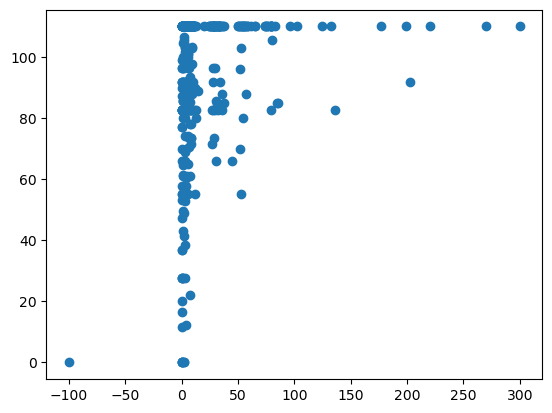

In [ ]:
import pandas as pd

df = pd.read_csv("data_1_6.csv")

import matplotlib.pyplot as plt
%matplotlib inline

#Graficamos para familiarizarnos con los datos
plt.scatter(df.Tiempo, df.Calificacion)

Se eliminaron los datos de la fila 430 hasta la la fila 445 ya que o no contenian datos o había un error en su formato.

Existe un dato atipico, el que se entrego con 4960 horas de anticipación, eliminaremos este dato ya que lo consideramos no plausible. Dicho dato se encontraba originalmente en la linea 31.

Creo que el modelo más adecuado para describir los datos es de KNN más cercanos debido a que no creo que se represente por alguna función.


Ahora separaremos los datos en una proporcion de 70-30 para los datos de entrenamiento y de prueba.

In [ ]:
from sklearn.model_selection import train_test_split

#Separamos los datos en prueba y entrenamiento para evitar el sobre ajuste.
x_train, x_test, y_train, y_test = train_test_split(df.Tiempo,df.Calificacion, train_size=.7)

#Observamos los promedios de los diferentes datos para saber si podría verse afectado el resultado.
print("Promedio de los tiempos de entrega de los datos de entrenamiento:", (x_train.mean()))
print("Promedio de los tiempos de entrega de los datos de prueba:", x_test.mean())
print("Promedio de las calificaciones de los datos de entrenamiento:", (y_train.mean()))
print("Promedio de las calificaciones de los datos de prueba:", y_test.mean())

Promedio de los tiempos de entrega de los datos de entrenamiento: 17.479995339050337
Promedio de los tiempos de entrega de los datos de prueba: 17.816160637658918
Promedio de las calificaciones de los datos de entrenamiento: 95.28693714765102
Promedio de las calificaciones de los datos de prueba: 93.49690782945736


Podemos observar que en la mayoría de las veces que se ejecuta el código los promedios son muy similares, por lo cual podríamos creer que nuestros datos son algo uniformes, lo cuál interpreto como una buena señal para más adelante, es decir deberiamos de obtener resultados parecidos entre la prueba y el entrenamiento.

Entrenaremos un modelo de regresión polinomial, especificamente uno cuadratico.

In [ ]:
import statsmodels.api as sm

#Los cambios son necesarios para que la función pueda usar los datos y compile el código.

#Cambiamos la forma de los datos a un array más amplio
xtemp_train = x_train.array.reshape(-1,1)
xtemp_test = x_test.array.reshape(-1,1)

from sklearn.preprocessing import PolynomialFeatures

#Generamos polinomiales
polyq_train = PolynomialFeatures(degree=2).fit(xtemp_train)
polyq_test = PolynomialFeatures(degree=2).fit(xtemp_test)

#Los tranformamos a un data frame
xq_train = pd.DataFrame(polyq_train.transform(xtemp_train))
xq_test = pd.DataFrame(polyq_test.transform(xtemp_test))

#Entrenamos el modelo
mq = sm.OLS(list(y_train),xq_train).fit()

print(mq.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     11.65
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           1.35e-05
Time:                        02:26:08   Log-Likelihood:                -1353.5
No. Observations:                 298   AIC:                             2713.
Df Residuals:                     295   BIC:                             2724.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             91.3387      1.557     58.659      0.0

Podemos observar el primer temino, uno lineal positivo, lo que quiere decir que por cada hora de anticipación la calificación aumenta 0.3698 Pts, podemos observar un coeficiente cuadratico negativo bastante pequeño que reduce el efecto del coeficiente lineal, lo que sugiere que el efecto que tienen las horas de anticipación disminuye con el tiempo. 

Creemos con un 95% de seguridad que el termino cuadratico y lineal tienen relación con la variable de salida.

Ahora utilizaremos la funcion PieceWiseRegressor utilizando regresiones cuadraticas para cada segmento y generaremos predicciones en los datos de prueba.

In [ ]:
from mlinsights.mlmodel import PiecewiseRegressor

#Creamos y entrenamos el modelo por segmentos
ms = PiecewiseRegressor('bins').fit(xq_train.iloc[:,1:],y_train)

#Creamos predicciones
y_hat_ms = ms.predict(xq_test.iloc[:,1:])


Ahora entrenaremos un modelo tipo KNN, utilizando un valor de K aleatorio 

In [ ]:
from sklearn.neighbors import KNeighborsRegressor as knn

#Creamos y entrenamos el modelo de KNN más cercanos
mk = knn(n_neighbors=28).fit(xtemp_train,y_train)

#Creamos predicciones
y_hat_mk = mk.predict(xtemp_test)

Ahora calcularemos el RSE de todos los modelos y escogeremos un ganador

In [ ]:
import numpy as np

#Calculamos los RSE's

y_hat_mq = mq.predict(xq_test)
RSS_mq = sum((list(y_test)-y_hat_mq)**2)
RSE_mq = np.sqrt(RSS_mq/(len(y_test)-1))
print("RSE del modelo cuadratico =", RSE_mq)

RSS_ms = sum((list(y_test)-y_hat_ms)**2)
RSE_ms = np.sqrt(RSS_ms/(len(y_test)-1))
print("RSE del modelo segmetado =", RSE_ms)

RSS_mk = sum((list(y_test)-y_hat_mk)**2) 
RSE_mk = np.sqrt(RSS_mk/(len(y_test)-1))
print("RSS de KNN más cercanos =", RSE_mk)



RSE del modelo cuadratico = 24.483667946174016
RSE del modelo segmetado = 23.623159387644954
RSS de KNN más cercanos = 23.328125224564847


Dentro de estos modelos primero pense en escoger el modelo segmentado ya que es el que tiene un error menor y es el que tiene una interpretabilidad decente dentro de los sistemas que exploramos, pero para la finalidad (buscamos que es saber si la hora de entrega influye en la calificación de los alumnos) usaría el modelo cuadratico ya que el RSE no es significativamente más grande pero la frase generada de interpretar los datos es mucho más sencilla, solo es una o dos frases a diferencia del segmentado que genera entre una y dos frases por segmento.  <p>     
Vale la pena mencionar que al observar la grafica final el modelo ode KNN más cercanos parece describir mucho mejor la scalificaciones pese a que no existe mucha diferencia en el error, pero su interpretabilidad es mala y no nos sirve bastante para nuestro objetivo.

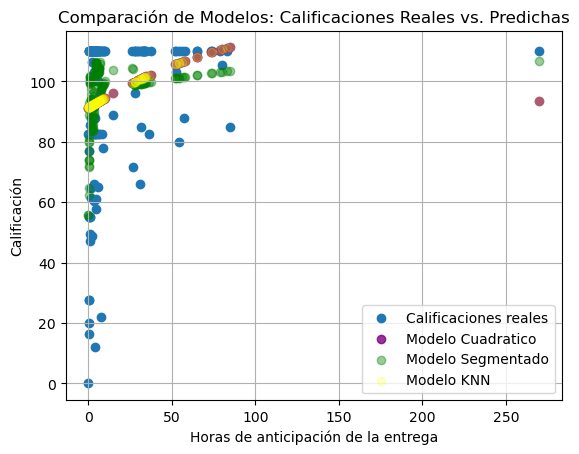

In [ ]:
#Graficamos para poder visualizar mejor nuestros resultados.

plt.scatter(x_test,y_test, label="Calificaciones reales", alpha=1)

plt.scatter(x_test, y_hat_mq, color= "purple", label="Modelo Cuadratico", alpha=0.8)
plt.scatter(x_test, y_hat_ms, color= "g", label="Modelo Segmentado", alpha= 0.4)
plt.scatter(x_test, y_hat_mq, color= "yellow", label="Modelo KNN", alpha= 0.2)

plt.xlabel("Horas de anticipación de la entrega")
plt.ylabel("Calificación")
plt.title("Comparación de Modelos: Calificaciones Reales vs. Predichas")
plt.legend()
plt.grid(True)